<a href="https://colab.research.google.com/github/Manthan26-cmd/Data-Science/blob/main/Water_Quality_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Intro**:

This project aims to develop a machine learning model to predict water potability based on various physical and chemical parameters.

**About Data:**

The dataset contains 3,276 water samples with 10 features including pH, hardness, solids, and other measurements, with a binary potability target variable.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**SETUP**

In [ ]:
# Base
import pandas as pd
import numpy as np
import random

In [ ]:
# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
%config InlineBackend.figure_format='retina'

In [ ]:
custom_params = {'grid.alpha': 0.5,
                 'axes.titlesize': 10,
                 #'figure.figsize': (10, 5),
                 'figure.titlesize': 14,
                 'axes.spines.top': False,   # Remove the top and right spines
                 'axes.spines.right': False, # Remove the top and right spines
                 'axes.labelsize': 8,
                 'xtick.labelsize': 8,
                 'ytick.labelsize': 8,
                 'font.size': 8              # General font size for text elements
                }
custom_palette = ['#5fa8d3', '#cae9ff', '#1b4965', '#62b6cb', '#bee9e8']
sns.set_theme(context='paper', style='whitegrid', palette=custom_palette, font='sans-serif', font_scale=1, color_codes=True, rc=custom_params)

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'use_inf_as_na option is deprecated*')

**Data Loading**

In [ ]:
data=pd.read_csv('/content/water_potability.csv')

In [ ]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


**EDA**

In [ ]:
# Create summary function
def df_summary(df):
    # Create summary table
    sum_table = pd.DataFrame(df.dtypes, columns=['data type'])
    sum_table['%_missing'] = df.isna().sum() / len(df) * 100
    sum_table['%_duplicates'] = df.duplicated().sum() / len(df) * 100
    # Get summary stats
    desc = pd.DataFrame(df.describe(include='all').transpose())

    # Get summary stats
    sum_table['min'] = desc['min'].values
    sum_table['max'] = desc['max'].values
    sum_table['mean'] = desc['mean'].values
    sum_table['median'] = desc['50%'].values
    sum_table['std dev'] = desc['std'].values

    # Round only numeric columns
    numeric_cols = sum_table.columns.drop('data type')
    for col in numeric_cols:
        sum_table[col] = sum_table[col].round(2)

    print(f'DataFrame Shape: {df.shape}\n')
    return sum_table

In [ ]:
# Print summary
df_summary(data)

DataFrame Shape: (3276, 10)



,data type,%_missing,%_duplicates,min,max,mean,median,std dev
ph,float64,14.99,0.0,0.00,14.00,7.08,7.04,1.59
Hardness,float64,0.00,0.0,47.43,323.12,196.37,196.97,32.88
Solids,float64,0.00,0.0,320.94,61227.20,22014.09,20927.83,8768.57
Chloramines,float64,0.00,0.0,0.35,13.13,7.12,7.13,1.58
Sulfate,float64,23.84,0.0,129.00,481.03,333.78,333.07,41.42
Conductivity,float64,0.00,0.0,181.48,753.34,426.21,421.88,80.82
Organic_carbon,float64,0.00,0.0,2.20,28.30,14.28,14.22,3.31
Trihalomethanes,float64,4.95,0.0,0.74,124.00,66.40,66.62,16.18
Turbidity,float64,0.00,0.0,1.45,6.74,3.97,3.96,0.78
Potability,int64,0.00,0.0,0.00,1.00,0.39,0.00,0.49


In [ ]:
data.groupby("Potability").apply(lambda x: x.isna().sum())

<ipython-input-15-fe2e7beb9a5c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data.groupby("Potability").apply(lambda x: x.isna().sum())


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
Potability,,,,,,,,,,
0,314,0,0,0,488,0,0,107,0,0
1,177,0,0,0,293,0,0,55,0,0


**Data Validation**

In [ ]:
# Check for physically impossible values
def identify_impossible_values(df):
    """
    Identifies physically impossible measurements in water quality data.
    """
    impossible_conditions = {
        'pH': (df['ph'] < 0) | (df['ph'] > 14),
        'Conductivity': df['Conductivity'] < 0,
        'Hardness': df['Hardness'] < 0
    }

    for feature, condition in impossible_conditions.items():
        impossible_count = condition.sum()
        if impossible_count > 0:
            print(f"{feature}: {impossible_count} impossible values found")
        else:
            print(f"{feature}: No imposible values found.")

identify_impossible_values(data)

pH: No imposible values found.
Conductivity: No imposible values found.
Hardness: No imposible values found.


**DATA DISTRIBUTION ANALYSIS**

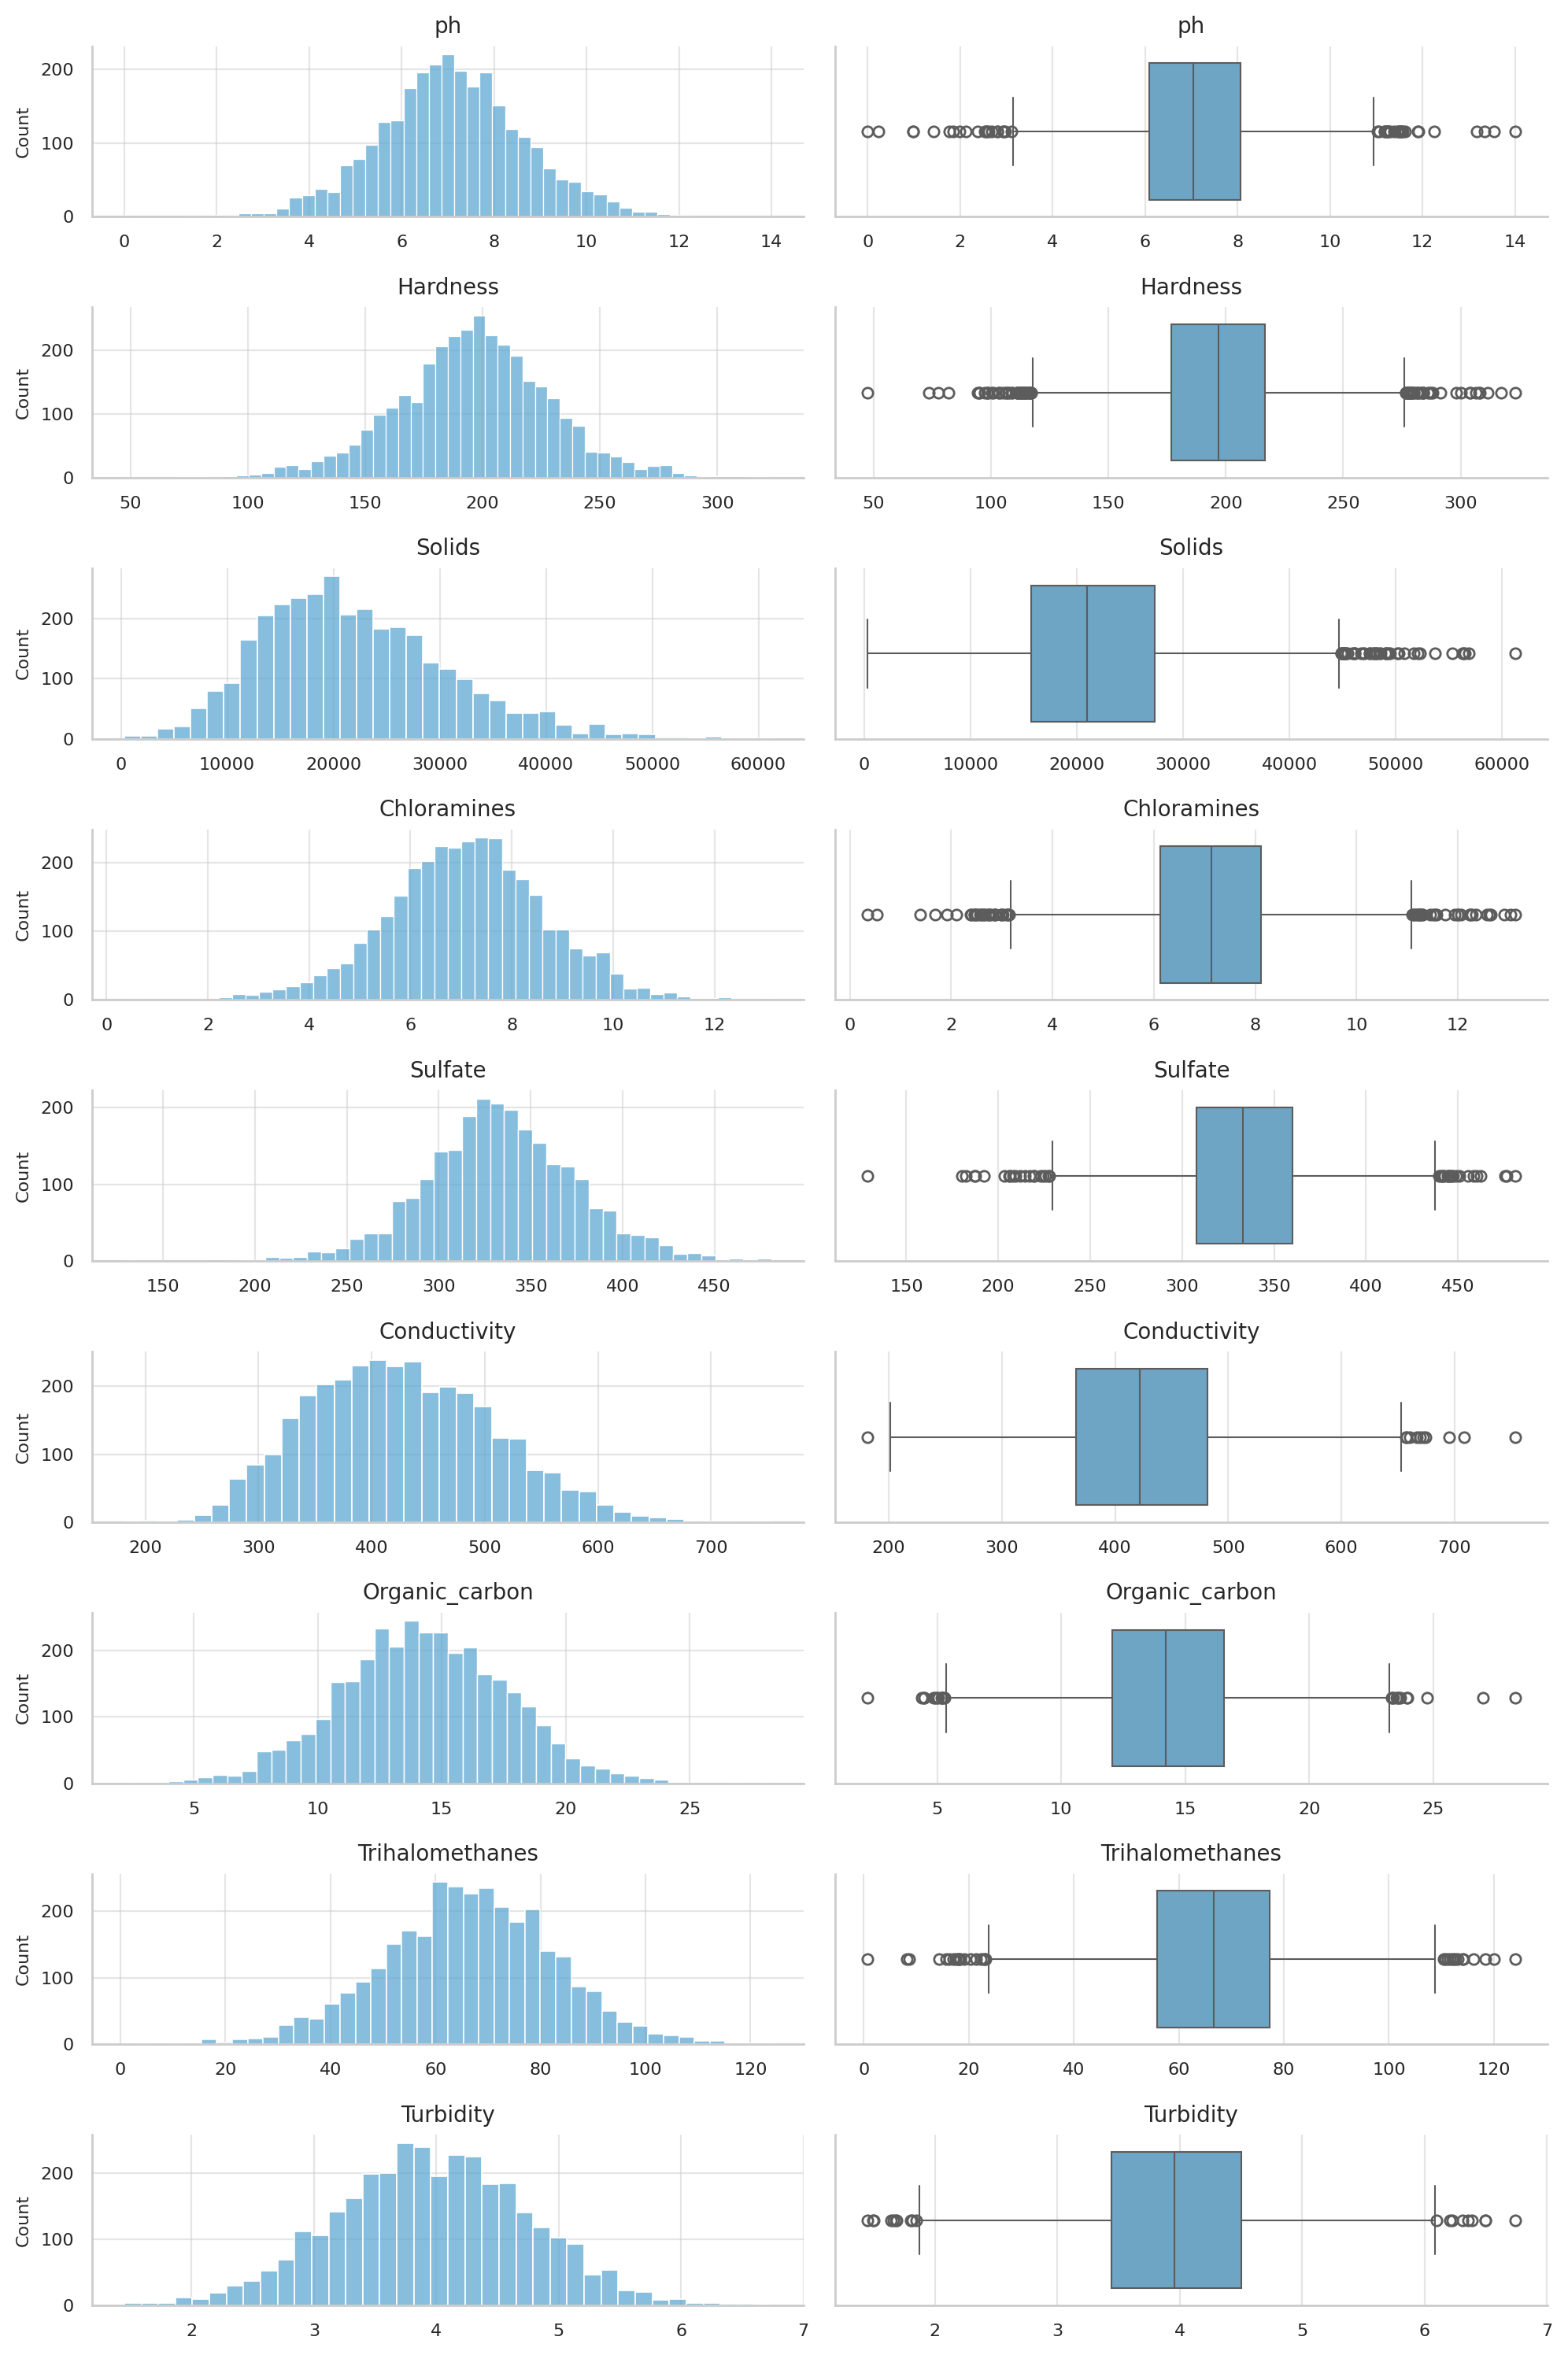

In [ ]:
# Create subplot grid
fig, axes = plt.subplots(9, 2, figsize=(10, 15))

# Plot histogram & boxplot for each feature
for idx, col in enumerate(data.columns[:-1]):
    # Histogram
    sns.histplot(data=data, x=col, ax=axes[idx,0])
    axes[idx,0].set_title(col)
    axes[idx,0].set_xlabel("")

    # Boxplot
    sns.boxplot(data=data, x=col, ax=axes[idx,1], orient='h', linewidth=.75)
    axes[idx,1].set_title(col)
    axes[idx,1].set_xlabel("")

# Adjust layout
plt.tight_layout(h_pad=1.5, w_pad=1.5)
plt.show()

**CLASS BALANCE**

Potability
0    1998
1    1278
Name: count, dtype: int64


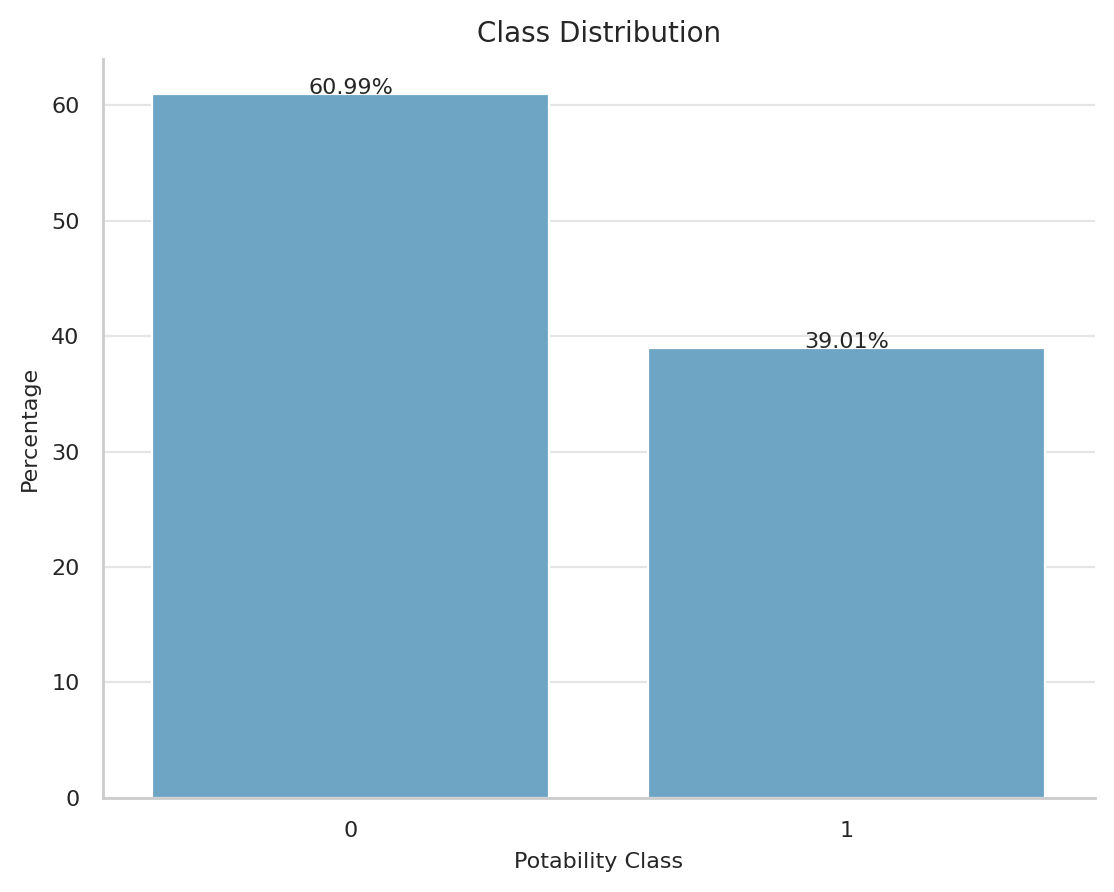

In [ ]:
print(data['Potability'].value_counts())

# Calculate class distribution in percentage
class_dist = (data['Potability'].value_counts(normalize=True) * 100).round(2)

# Create figure and axes
fig, axes = plt.subplots()
# Plot class distribution
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Class Distribution')
plt.xlabel('Potability Class')
plt.ylabel('Percentage')
for i, v in enumerate(class_dist):
   plt.text(i, v, f'{v}%', ha='center')
plt.show()

# Data Relationship Analysis

**Feature Co-relation Analysis(Linear Relationships)**

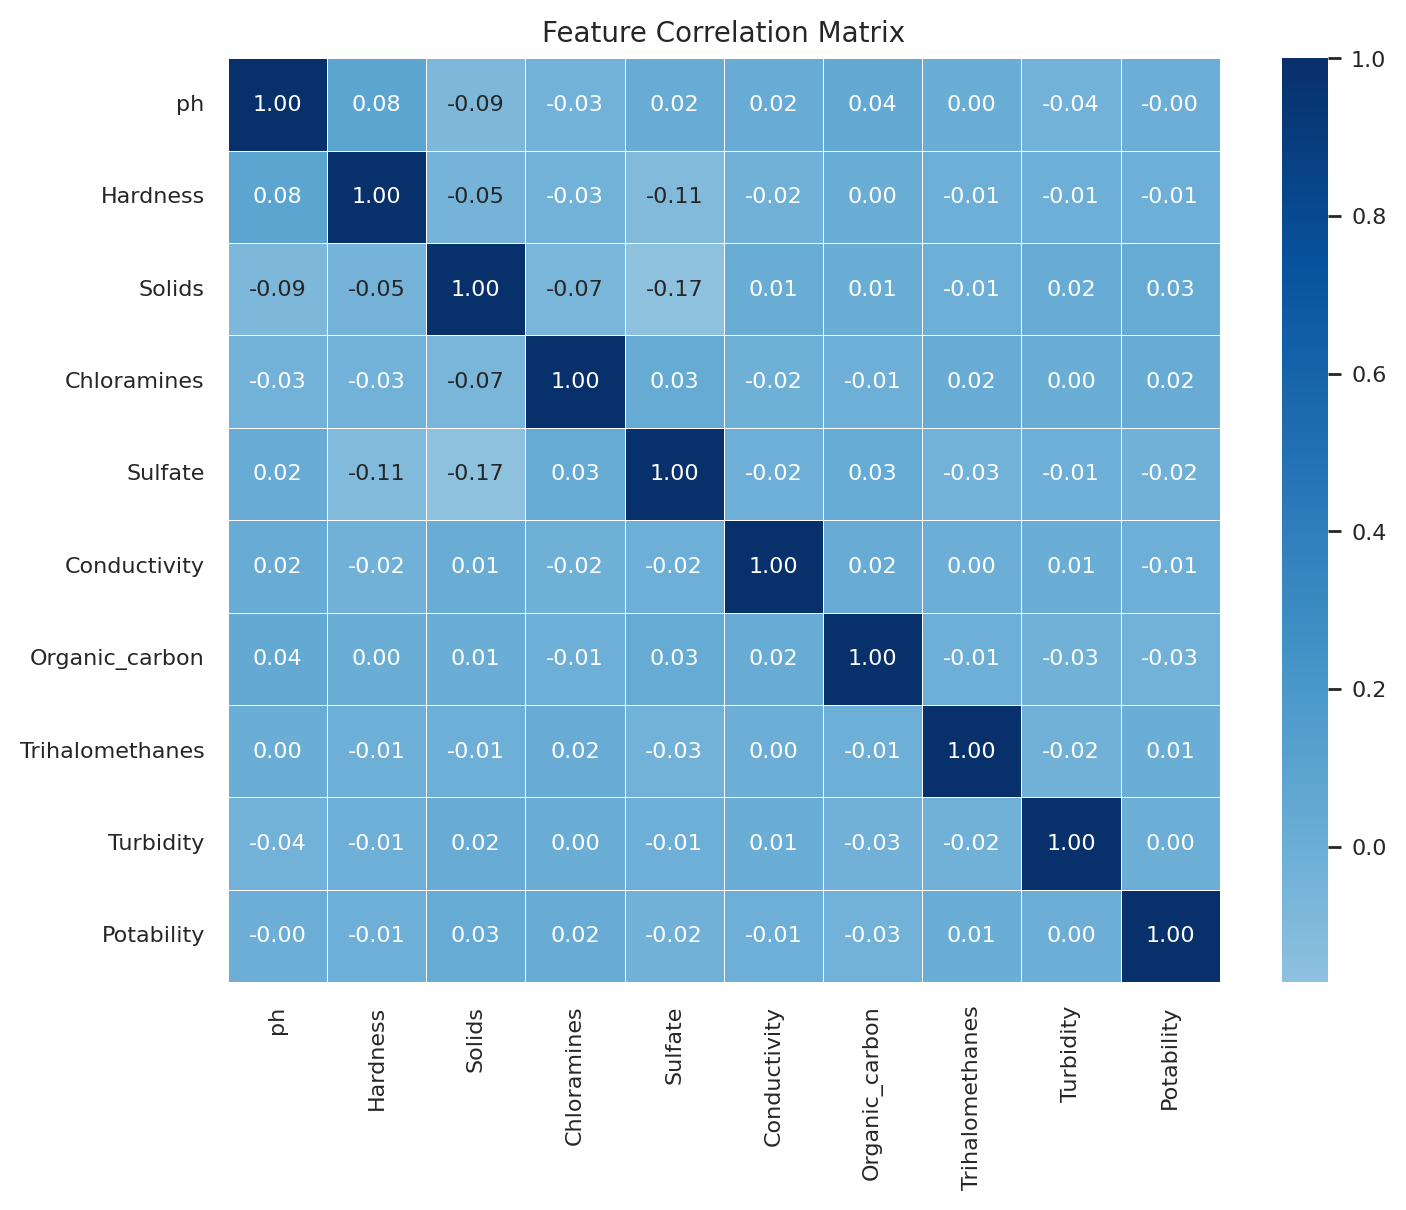

In [ ]:
# Visualize correlations
fig, axes = plt.subplots(figsize=(8,6), dpi=100)
sns.heatmap(data.corr(), annot=True, fmt=".2f", center=0, cmap='Blues',linecolor='white', linewidths=0.2)
plt.title('Feature Correlation Matrix')
plt.show()

**Non-Linear Relationships**

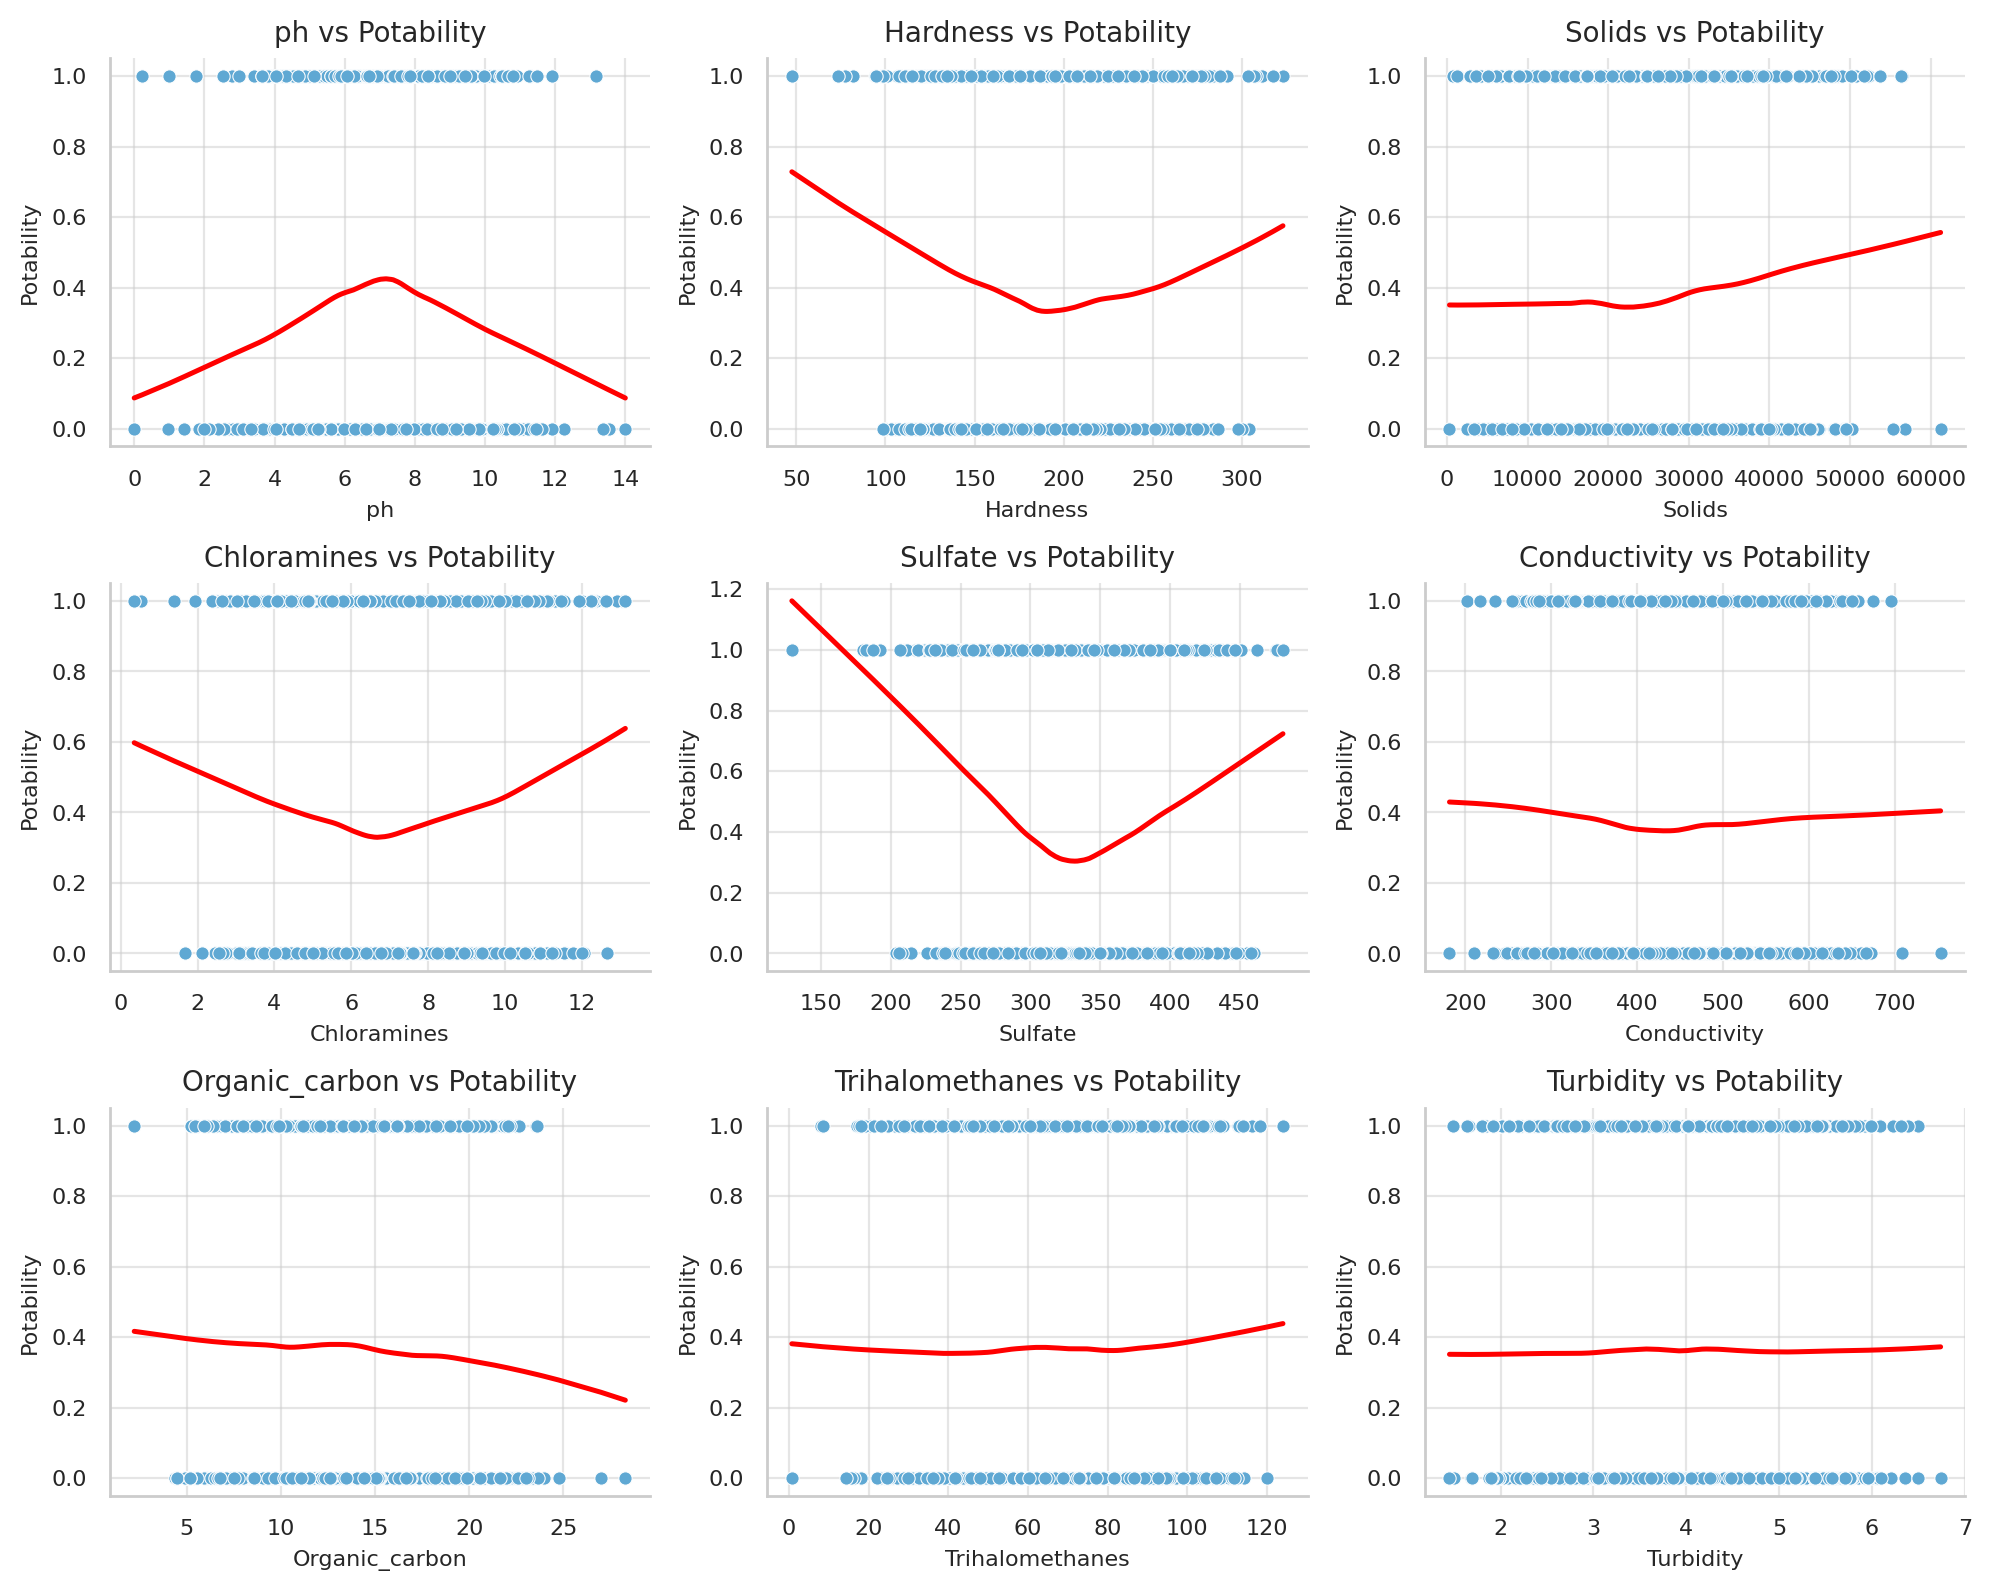

In [ ]:
# Create subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
# Flatten the 3x3 grid of axes into a 1D array for easy iteration
axes = axes.ravel()

# Loop through each feature (excluding the target 'Potability') and create scatter plots
for idx, column in enumerate(data.columns[:-1]):    # Exclude the last column ('Potability'
    # Plot a scatter plot for the feature against 'Potability'
    sns.scatterplot(data=data, x=column, y='Potability', ax=axes[idx])
    # Add a red trend line using LOWESS (locally weighted scatterplot smoothing) to capture non-linear patterns
    sns.regplot(data=data, x=column, y='Potability', ax=axes[idx], scatter=False, color='red', lowess=True)
    axes[idx].set_title(f'{column} vs Potability')

plt.tight_layout()
plt.show()

High Dimensinional Feature Scale Analysis

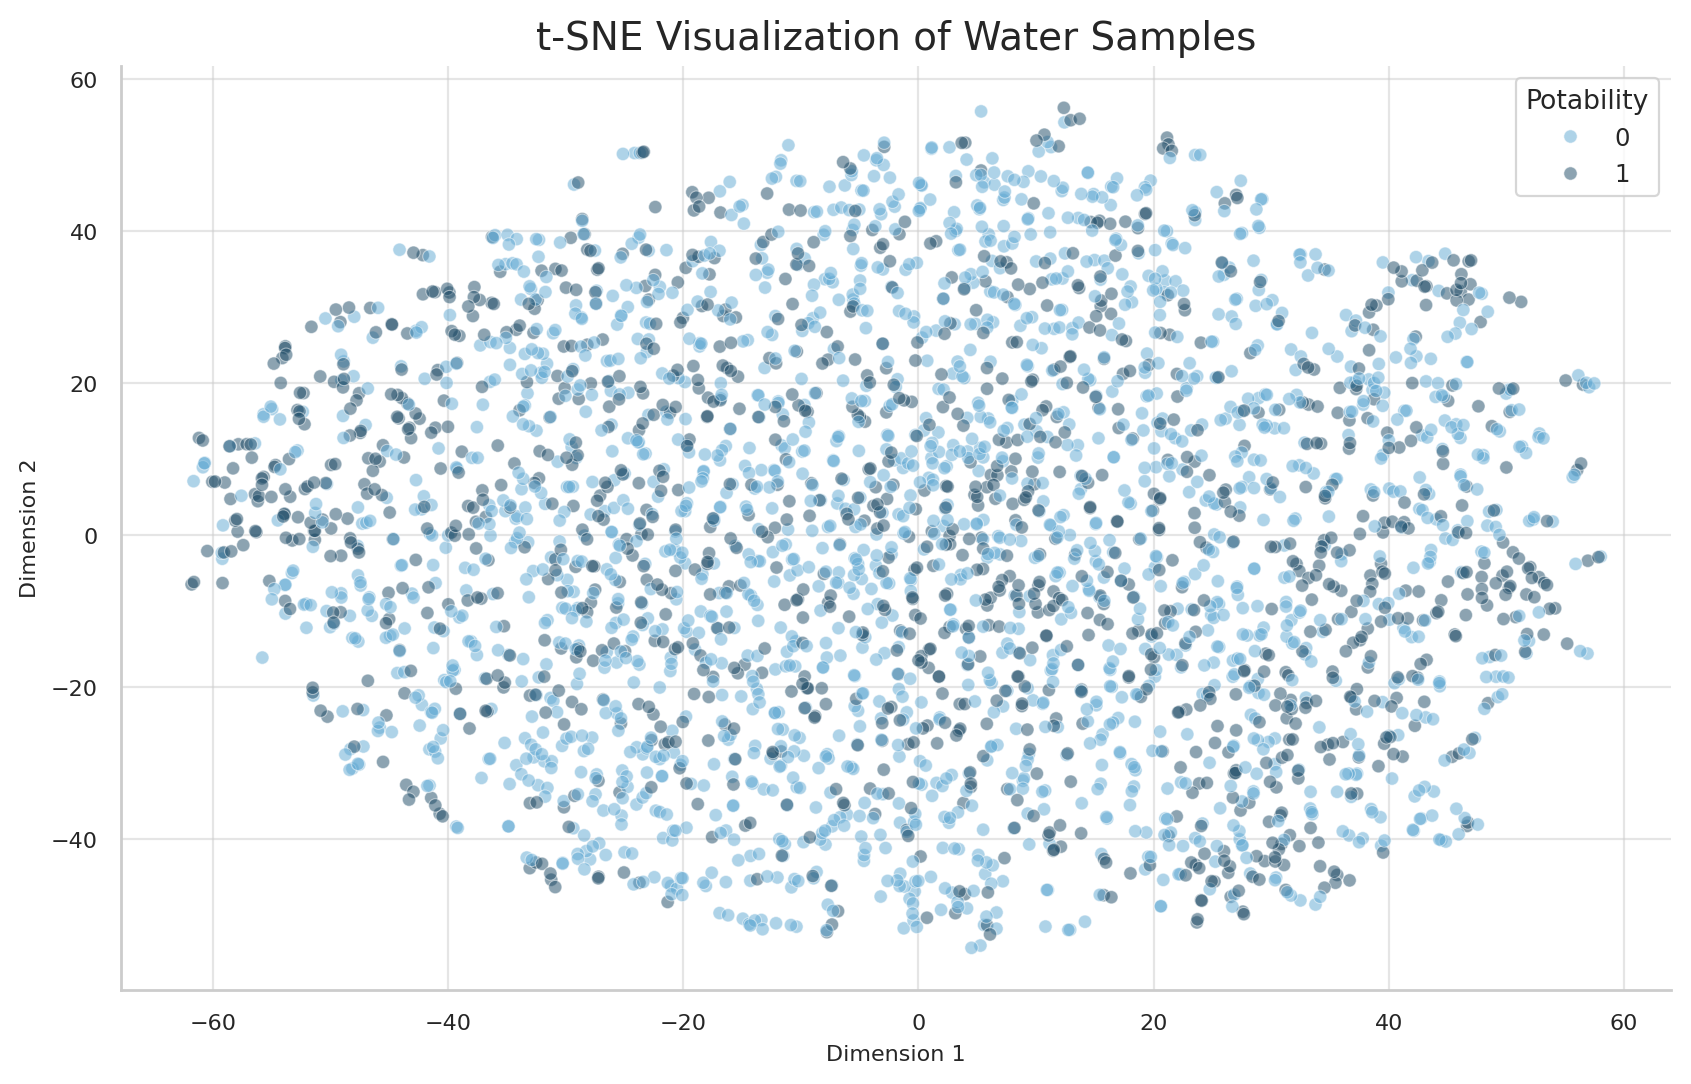

In [ ]:
# Handle missing values and scale features
X_tsne_imputed = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean',
                            add_indicator=True).fit_transform(data.drop('Potability', axis=1))
X_tsne_scaled = RobustScaler().fit_transform(X_tsne_imputed)
y_tsne = data['Potability']

# Create t-SNE object
tsne = TSNE(n_components=2, random_state=42)
# Apply t-SNE for dimensionality reduction
X_tsne = tsne.fit_transform(X_tsne_scaled) # X_tsne is a 2D array(each row = one water sample)

# Convert t-SNE results and labels into a DataFrame for easier plotting
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Potability'] = y_tsne  # Add y-labels to the DataFrame

# Plot t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Potability',
                palette={0: custom_palette[0], 1: custom_palette[2]},
                alpha=0.5)
plt.title('t-SNE Visualization of Water Samples', fontsize=14)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


# Baseline Model


**Data Split**

In [ ]:
# Prepare data
X_base = data.drop('Potability', axis=1)
y_base = data['Potability']

# Split data into train and test sets
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base, y_base,
    test_size=0.2,
    random_state=42,
    stratify=y_base    # This ensures same class proportions in train and test
)

**Model Pipeline**

In [ ]:
# Create pipeline
baseline_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance', add_indicator=True)), # Handle missing values using KNN approach
    ('rf', RandomForestClassifier(
        class_weight='balanced',
        bootstrap=True,
        max_features='sqrt',
        oob_score=True,
        random_state=42,
        n_jobs=-1))
])

# Define parameter search space for RF optimization
param_grid = {
    'rf__n_estimators': [400, 500],        # number of trees
    'rf__max_depth': [4, 6],               # max depth of each tree
    'rf__min_samples_split': [15, 20],     # min samples to split a node
    'rf__min_samples_leaf': [8, 10, 12],   # min samples in a leaf
}

# Setup RandomizedSearchCV for efficient hyperparameter tuning
random_search = GridSearchCV(
    baseline_pipeline,
    param_grid,
    cv=5,           # 5-fold cross-validation
    scoring='f1'    # Optimize both `F1-score` and `precision`
)

# Baseline Model Evaluation

In [ ]:
def evaluate_model(best_model, X_train, y_train, X_test, y_test):
    """
    Evaluate model performance including classification metrics, calibration,
    and confidence distribution.

    Args:
        model: Trained model with predict and predict_proba methods
        X_train, y_train: Training data and labels
        X_test, y_test: Test data and labels
    """
    # Get predictions for both sets
    y_train_pred = best_model.predict(X_train)
    y_train_prob = best_model.predict_proba(X_train)[:, 1]   # Probabilities for positive class

    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:, 1]     # Probabilities for positive class

    performance_metrics = {
        'train_report': classification_report(y_train, y_train_pred),
        'test_report': classification_report(y_test, y_test_pred)
    }

    # Print classification metrics
    print("\nTraining Set Performance:")
    print(performance_metrics['train_report'])
    print("\nTest Set Performance:")
    print(performance_metrics['test_report'])

    # Analyze prediction confidence (apply function)
    analyze_confidence_distribution(y_train_prob, y_test_prob)

    return y_train_prob, y_test_prob, performance_metrics


def analyze_confidence_distribution(train_prob, test_prob):
    """
    Analyze and visualize model confidence in predictions.
    Args:
        train_prob: Predicted probabilities for training set
        test_prob: Predicted probabilities for test set
    """
    # Plot probability distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    for idx, (label, prob) in enumerate([("Training Set", train_prob), ("Test Set", test_prob)]):
        ax = ax1 if idx == 0 else ax2
        # Use seaborn's histplot with stat='percent'
        sns.histplot(data=prob, bins=np.linspace(0, 1, 11),
                    stat='percent',     # Converts to percentages
                    ax=ax,
                    color=custom_palette[2])

        ax.set_xlabel('Predicted probability of being Potable (Class 1)')
        ax.set_ylabel('Percentage of samples (%)')
        ax.set_title(f'{label} Probability Distribution')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print confidence level analysis
    confidence_levels = {
        'High (>0.7)': (lambda p: p > 0.7),
        'Medium (0.5-0.7)': (lambda p: (p > 0.5) & (p <= 0.7)),
        'Low (<0.5)': (lambda p: p <= 0.5)
    }

    for label, probabilities in [('Train Set', train_prob), ('Test Set', test_prob)]:
        print(f"\n{label} Confidence Distribution:")
        for level, condition in confidence_levels.items():
            pct = np.mean(condition(probabilities))
            print(f"{level}: {pct:.1%}")

Training model with GridSearchCV...

Best parameters found:
{'rf__max_depth': 6, 'rf__min_samples_leaf': 12, 'rf__min_samples_split': 15, 'rf__n_estimators': 500}

Evaluating model performance...

Training Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1598
           1       0.72      0.66      0.69      1022

    accuracy                           0.77      2620
   macro avg       0.76      0.75      0.75      2620
weighted avg       0.77      0.77      0.77      2620


Test Set Performance:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       400
           1       0.52      0.47      0.50       256

    accuracy                           0.63       656
   macro avg       0.60      0.60      0.60       656
weighted avg       0.62      0.63      0.62       656



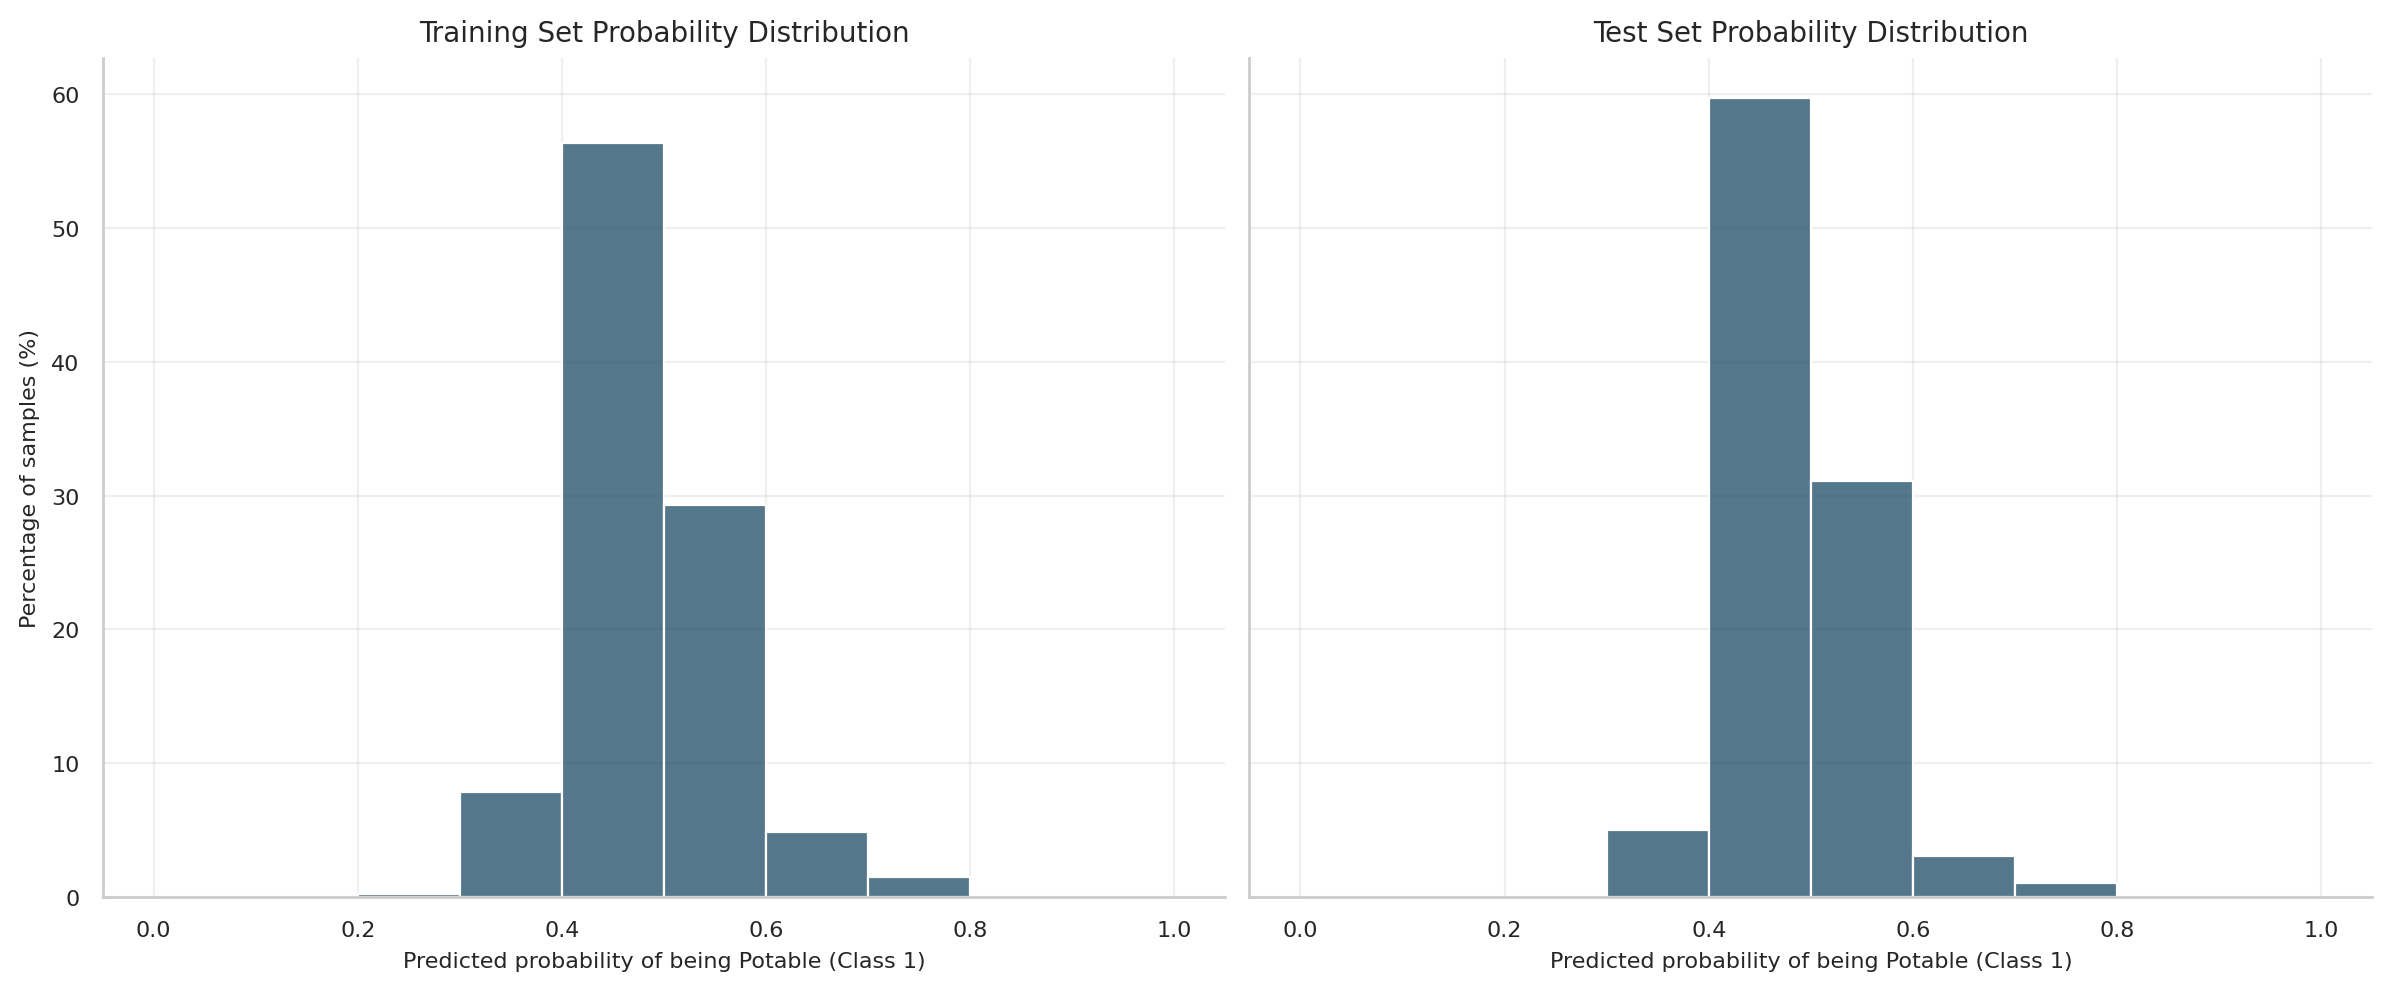


Train Set Confidence Distribution:
High (>0.7): 1.5%
Medium (0.5-0.7): 34.2%
Low (<0.5): 64.4%

Test Set Confidence Distribution:
High (>0.7): 1.1%
Medium (0.5-0.7): 34.1%
Low (<0.5): 64.8%


In [ ]:
# Fit the model
print("Training model with GridSearchCV...")
random_search.fit(X_train_base, y_train_base)

# Retrieve the model with the best hyperparameters found during the random search
best_baseline_model = random_search.best_estimator_
print("\nBest parameters found:")
print(random_search.best_params_)

# Model Evaluation
print("\nEvaluating model performance...")
y_train_base_prob, y_test_base_prob, baseline_performance_metrics = evaluate_model(best_baseline_model, X_train_base, y_train_base, X_test_base, y_test_base)

# **Feature Importance In Random Forest**

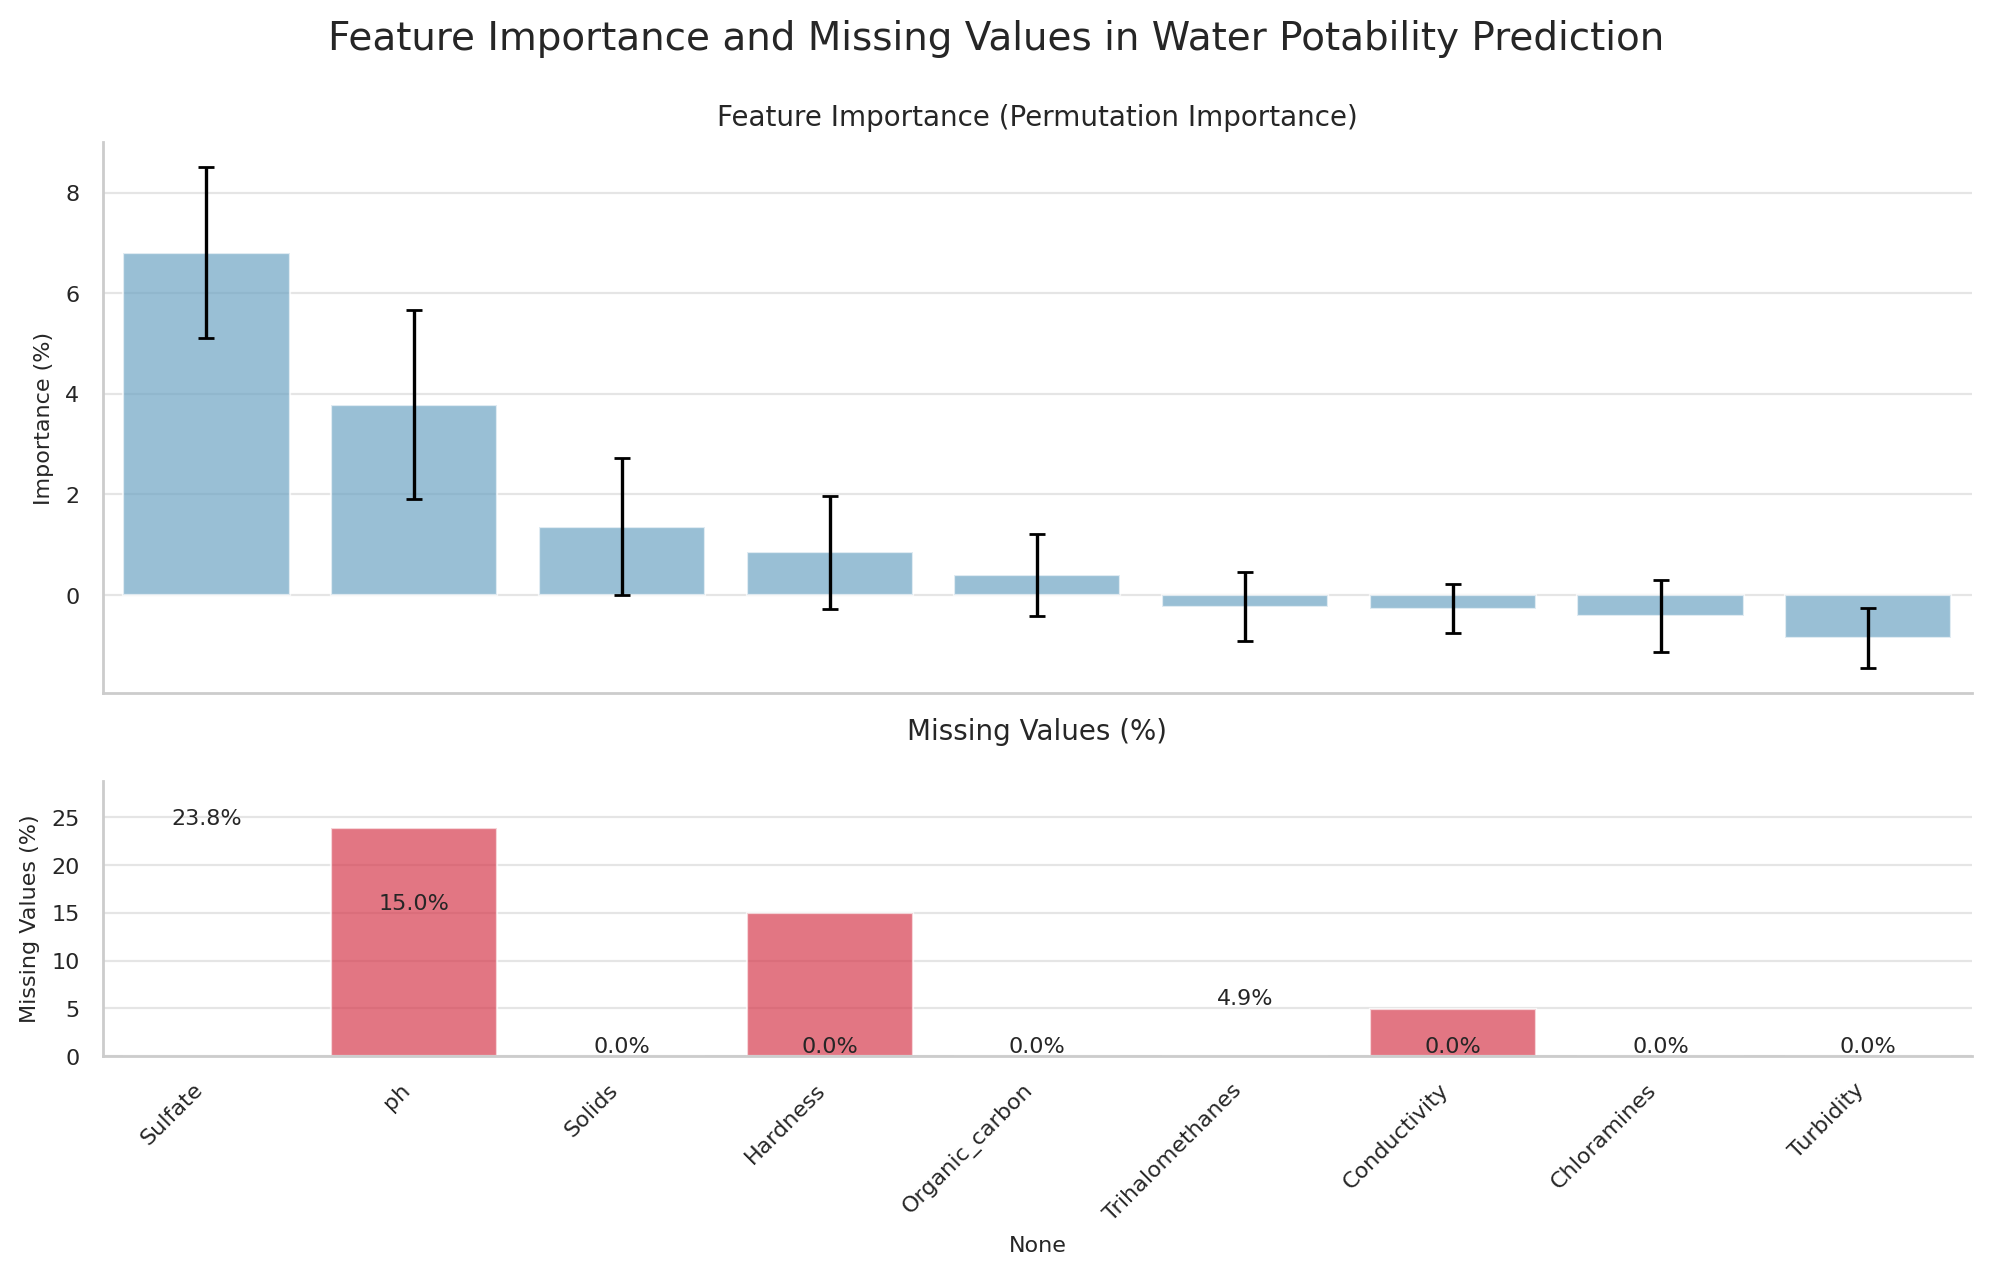

In [ ]:
def analyze_feature_importance_and_completeness(model,df, X_test, y_test):
    """Analyzes feature importance using permutation importance and missing value percentages."""

    # Step 1: Calculate feature importance using permutation importanc
    result = permutation_importance(
        best_baseline_model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42,
        scoring='f1'
    )

    importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': result.importances_mean,        # Average importance over `n_repeats`
        'importance_std': result.importances_std,     # Standard deviation
        'importance_percentage': result.importances_mean * 100
    }).sort_values('importance', ascending=False)

    # Step 2: Compute missing value percentages
    missing_pct = df.isna().sum() / len(df) * 100
    missing_pct = missing_pct[importance_df['feature']]  # Align with sorted features

    # Step 3: Plot feature importance and missing values
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, height_ratios=[2, 1])

    # Feature Importance Plot
    sns.barplot(data=importance_df, x='feature', y='importance_percentage', ax=ax1, color=custom_palette[0], alpha=0.7)
    ax1.set_ylabel('Importance (%)')
    ax1.set_title('Feature Importance (Permutation Importance)')
    ax1.errorbar(range(len(importance_df)), importance_df['importance_percentage'],
                 yerr=importance_df['importance_std'] * 100, fmt='none', color='black', capsize=3)  # Add error bars

    # Missing Value Plot
    sns.barplot(x=X_test.columns, y=missing_pct, ax=ax2, color='#ef233c', alpha=0.7)
    ax2.set_ylabel('Missing Values (%)')
    ax2.set_title('Missing Values (%)', pad=15)
    ax2.set_ylim(0, max(missing_pct)+5)
    for i, v in enumerate(missing_pct):
        ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

    # Formatting
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # Replace fig.suptitle line with:
    fig.suptitle('Feature Importance and Missing Values in Water Potability Prediction', y=1.05)
    plt.show()


# Apply the function
analyze_feature_importance_and_completeness(best_baseline_model, data, X_test_base, y_test_base)

Analysis of Contradictions in Water Potability Classification

In [ ]:
# Find similar samples with different potability labels
def find_contradictions_in_data(X, y, n_neighbors=5):    # 5 neighbors, like in previous model training
    """
    Find water samples that have similar chemical properties but different potability labels.
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Water quality measurements (pH, hardness, etc.)
    y : array-like of shape (n_samples,)
        Potability labels (0 for non-potable, 1 for potable)
    n_neighbors : int, default=3
        Number of neighbors to consider for each sample

   Returns:
    --------
    X_imputed : array-like
        Data after imputation.
    X_scaled : array-like
        Standardized data for fair distance comparison.
    missing_mask : array-like of bool
        Mask of missing values in the original data.
    """

    def preprocess_data(X):
        # Standardize features for fair distance comparison
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)             # Learns parameters AND transform data
        # Fill missing values using KNN
        imputer = KNNImputer(n_neighbors=n_neighbors)  # n_neighbors same as in pipeline
        X_imputed = imputer.fit_transform(X_scaled)

        return X_imputed, X_scaled

    # Preprocess data: handle missing values and scale features
    X_imputed, X_scaled = preprocess_data(X)

    # Find nearest neighbors for each sample
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(X_imputed)

    # Get distances and indices of nearest neighbors for each sample
    distances, indices = nn.kneighbors(X_imputed)

    # Detect contradictions where similar samples have different labels
    contradictions = []
    for i in range(len(X)):
        neighbors_labels = y[indices[i]]     # Labels of neighboring samples
        neighbors_idxs = indices[i]          # Indices of neighboring samples

        # Check if neighbors have differing labels
        if len(set(neighbors_labels)) > 1:
            main_label = y[i]
            # Count neighbors with labels different from the current sample
            different_labels = sum(1 for label in neighbors_labels if label != main_label)
            contradiction_percentage = (different_labels / n_neighbors) * 100
            # Save contradiction details
            contradictions.append({
                'sample_idx': i,                         # Index of current sample
                'sample_label': y[i],                    # Potability of current sample
                'neighbors_idxs': neighbors_idxs,
                'neighbors_labels': neighbors_labels,    # Potability of similar samples
                'contradiction_%': contradiction_percentage
        })

    # Summarize the results
    print(f"Found {len(contradictions)} cases out of {len(X)} total samples, where neigbouring point/s have different lables.")
    print(f"That's {len(contradictions)/len(X)*100:.1f}% of our data showing contradictions.")

    print(f"\nAvg. % of contradictioning neighbours: {round(sum(case['contradiction_%'] for case in contradictions) / len(contradictions), 1)}%")


# Call the function
find_contradictions_in_data(X_base, y_base)

Found 2730 cases out of 3276 total samples, where neigbouring point/s have different lables.
That's 83.3% of our data showing contradictions.

Avg. % of contradictioning neighbours: 39.7%


# **Enhancing Model**

In [ ]:
class WaterChemistryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.engineered_features = {
            'LSI_indicator': lambda X: X['ph'] + np.log1p(X['Hardness']) - np.log1p(X['Conductivity']),
            'TDS_EC_ratio': lambda X: X['Solids'] / np.clip(X['Conductivity'], 1e-10, None),
            'mineral_balance': lambda X: X['Sulfate'] * X['Hardness'] / 1000,
            'chlorine_ph_effectiveness': lambda X: X['ph'] * np.log1p(X['Hardness']) / np.log1p(np.clip(X['Conductivity'], 1e-10, None))
        }

    def fit(self, X, y=None):
        # Store input feature names
        self.feature_names_in_ = X.columns.tolist()
        return self

    def transform(self, X):
        X_new = pd.DataFrame(X).copy()
        # Add engineered features
        for name, func in self.engineered_features.items():
            X_new[name] = func(X_new)
        return X_new

    def get_feature_names_out(self, feature_names_in=None):
        # If no input features provided, use stored ones
        if feature_names_in is None:
            feature_names_in = self.feature_names_in_
        # Return original + engineered features
        return np.array(list(feature_names_in) + list(self.engineered_features.keys()))

In [ ]:
# Prepare data
X = data.drop('Potability', axis=1)
y = data['Potability']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)      # This ensures same class proportions in train and test

In [ ]:
# Create the enhanced pipeline that integrates all improvements
improved_pipeline = Pipeline([
    # Step 1: Handle missing values using KNN imputation
    ('imputer', KNNImputer(
        n_neighbors=5,
        weights='distance',              # Weight closer samples more heavily for better local estimates
        metric='nan_euclidean',          # Performs internal scaling for distance calculations
        add_indicator=True).set_output(transform="pandas")),
    ('feature_engineering', WaterChemistryTransformer()),

    # Step 2: Random Forest Classifier with probability calibration
    ('clf', CalibratedClassifierCV(
        estimator=RandomForestClassifier(
            bootstrap=True,             # Enables resampling for robustness
            class_weight='balanced',    # Adjusts for imbalanced classes
            max_features='sqrt',        # Uses sqrt(number of features) at each split
            oob_score=True,             # Enables out-of-bag evaluation for generalization
            random_state=42             # Ensures reproducibility
        ),
        cv=5,                           # 5-fold cross-validation to calibrate probability estimates
        method='sigmoid'                # Sigmoid calibration for smoother probability outputs
    ))
])

# Hyperparameter tuning grid
param_grid = {
    'imputer__n_neighbors': [10, 15, 20],            # Different numbers of neighbors for KNN imputation
    'clf__estimator__n_estimators': [400, 500],      # Number of trees in the Random Forest
    'clf__estimator__max_depth': [6, 8],             # Maximum depth of trees
    'clf__estimator__min_samples_split': [15, 20],   # Minimum samples required to split an internal node
    'clf__estimator__min_samples_leaf': [8, 10],     # Minimum number of samples per leaf node
}

# Set up hyperparameter tuning with RandomizedSearchCV
random_search = GridSearchCV(
    improved_pipeline,              # The complete pipeline (preprocessing + model)
    param_grid,                     # Grid of hyperparameters to search
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=['f1', 'precision'],    # Optimize both `F1-score` and `precision`
    refit='f1',                     # Select the best model based on F1-score
    error_score='raise',
    verbose=2,
    n_jobs=-1                       # Use all available CPU cores for speed
)

In [ ]:
def plot_calibration_curves(y_train, train_prob, y_test, test_prob, n_bins=10):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Define 'axes'
    datasets = [("Training Set", y_train, train_prob), ("Test Set", y_test, test_prob)]

    for idx, (label, y, y_prob) in enumerate(datasets):
        # Calibration curve (top row)
        prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=n_bins)
        sns.lineplot(x=prob_pred, y=prob_true, marker="o", ax=axes[idx], label=label)
        sns.lineplot(x=[0, 1], y=[0, 1], ax=axes[idx],
                    linestyle="--", color="gray", label="Perfect calibration")
        axes[idx].set_xlabel('Mean predicted probability (Positive class: 1)')
        axes[idx].set_ylabel('Fraction of positives (Positive class: 1)')
        axes[idx].set_title(f'{label} Calibration')
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Fit the model
print("Training model with GridSearchCV...")
random_search.fit(X_train, y_train)

# Retrieve the model with the best hyperparameters found during the random search
best_model = random_search.best_estimator_
print("\nBest parameters found:")
print(random_search.best_params_)

# Model Evaluation
print("\nEvaluating model performance...")
y_train_prob, y_test_prob, performance_metrics = evaluate_model(best_model, X_train, y_train, X_test, y_test)

# Print calibration plots
plot_calibration_curves(y_train, y_train_prob, y_test, y_test_prob)

Training model with GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
